### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Scripts/Fake Folder Copy/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [2]:
date_start = '2018-05-01'
date_end = '2019-05-31'

write_excel = 'yes'
write_pdf = 'yes'

colors = {'color01':'#2a4d69',
          'color02':'#4b86b4',
          'color03':'#adcbe3',
          'color04':'#e7eff6',
          'color05':'#63ace5'}

d = date_end[:4] + ' - ' + date_end[5:7] + ' - ' + calendar.month_abbr[int(date_end[5:7])] + ' - '
report_title = d + ' IoT and Feather Report for Digi-Key'

report_dict = {}
report_dict['year and month'] = jb_dates(pd.Series(date_end), 'year and month pretty')[0]
report_dict['now'] = str(dt.datetime.now().date())

pdf_path = '/Users/jarad/Scripts/Fake Folder Copy/Finance/Recurring/IoT and Feather Report for Digi-Key/Docs/'

html_path = '/Users/jarad/Scripts/Fake Folder Copy/Finance/Recurring/IoT and Feather Report for Digi-Key/HTML/'
html_title = 'IoT and Feather Report for Digi-Key.html'

style_sheet_path = '/Users/jarad/Scripts/Fake Folder Copy/CSS Stylesheets/Recurring Reports Stylesheet.css'

csv_path = '/Users/jarad/Scripts/Fake Folder Copy/Finance/Recurring/IoT and Feather Report for Digi-Key/CSVs/'
image_path = '/Users/jarad/Scripts/Fake Folder Copy/Finance/Recurring/IoT and Feather Report for Digi-Key/Images/'

### Note:
* In this script we don't just want the final classification of some part as seen on the website.
* We want all parts that have sometime or another, in their classification hierarchies, been deemed a Feather or IoT part.
* See a little further down under "Quick check using PN 2821" for an example;

### Get raw data

In [3]:
ptc = pd.read_sql(
'''
SELECT
part_id AS 'part id',
categories_id AS 'cat id'
FROM products_to_categories
WHERE categories_id IN
(SELECT
categories_id
FROM categories)
''', db)

cats = pd.read_sql(
'''
SELECT
categories_id AS 'cat id',
parent_id AS 'parent id'
FROM categories
#WHERE categories_status = 1 # tempting to exclude any non-working cats, but we want historical data, so don't do this
''', db)

names = pd.read_sql(
'''
SELECT
c.categories_id AS 'cat id',
c.parent_id AS 'parent id',
LOWER(cd.categories_name) AS name
FROM categories c
JOIN categories_description cd ON c.categories_id = cd.categories_id
#WHERE c.categories_status = 1
''', db)

main_names = names[['cat id','name']][names['parent id'] == 0].copy()

# DO NOT USE THIS HERE
# this query will return the category that is displayed on the customer part profile
# this will NOT return all cateogries some part belongs to
master_cats = pd.read_sql(
'''
SELECT
part_id,
master_categories_id
FROM parts
''', db)

part_names = pd.read_sql(
'''
SELECT
part_id AS 'part id',
products_name AS 'part name'
FROM products_description
''', db)            

### Recursion for categories

In [4]:
ptc_matrix = ptc.values
cats_matrix = cats.values

dict_ = {}
counter = 0
for i in range(len(ptc_matrix)):
    ls = [] # each PN gets its own empty list
    pn = ptc_matrix[i,0] # get PN
    ls.append(pn) # send to list
    sub_cat = ptc_matrix[i,1] # get bottom cat
    while sub_cat != 0: # start recursion, when we hit zero we have found the top cat
        ls.append(sub_cat) # send each layer to list        
        new_sub_cat = cats_matrix[cats_matrix[:,0] == sub_cat][0][1] # get each subsequent cat, from bottom to top
        sub_cat = new_sub_cat
    dict_[counter] = ls # send to dict
    counter += 1 # keep counting, for dict index

In [5]:
# find how many columns we need in our df
find_max_length = []
for k,v in dict_.items():
    find_max_length.append(len(v))
max_length = np.max(find_max_length)

In [6]:
# if list in dict_ does not have N elements, add N-x elements to make it have N elements
# this is for our df creation, next up
for k,v in dict_.items():
    if len(v) != max_length:
        to_insert = max_length - len(v)
        for i in range(to_insert):
            v.insert(1,0)

In [7]:
# create empty df, with column names
cols = []
for i in np.arange(max_length):
    cols.append(str(i))
df = pd.DataFrame(columns = cols)

In [8]:
# for each element in your dict, add to a df
for k,v in dict_.items():
    for i in range(max_length):
        df.loc[k, str(i)] = v[i]

In [9]:
# merge to get "top cat name"
df2 = pd.merge(df, main_names, left_on = '3', right_on = 'cat id').drop('cat id',1)
df2.rename(columns = {'0':'part id',
                      '1':'sub cat 02',
                      '2':'sub cat 01',
                      '3':'top cat',
                      'name':'top cat name'}, inplace = True)

# merge to get part names
df3 = pd.merge(df2, part_names, on = 'part id')

# make it look nice
cols = ['part id','part name','top cat name','top cat','sub cat 01','sub cat 02']

# rename for final df
parts_and_cats = df3[cols].copy()

### Check against main query

In [10]:
if len(ptc) == len(parts_and_cats):
    print('you have categorized all parts from your main query')
else:
    print('you missed some PNS, and here they are')
    print(ptc['part id'][~ptc['part id'].isin(parts_and_cats['part id'])])

you missed some PNS, and here they are
194    104
195    105
196    106
197    107
246    111
247    112
248    113
249    114
250    115
251    116
252    117
253    118
254    119
Name: part id, dtype: int64


In [11]:
print('there are %i unique PNs' % len(parts_and_cats['part id'].unique()))

there are 4119 unique PNs


### Assign pt cats
* Either "feather", "iot", or "both"

In [12]:
parts_and_cats['pt cat'] = ''

for part_id in parts_and_cats['part id'].unique():
    
    df = parts_and_cats[parts_and_cats['part id'] == part_id]

    if 'feather' in df.loc[:,'top cat name'].values and 'internet of things - iot' not in df.loc[:,'top cat name'].values:
        res = 'feather'
    elif 'feather' not in df.loc[:,'top cat name'].values and 'internet of things - iot' in df.loc[:,'top cat name'].values:
        res = 'iot'
    elif 'feather' in df.loc[:,'top cat name'].values or 'internet of things - iot' in df.loc[:,'top cat name'].values:
        res = 'both'
    else:
        res = 'n/a'
    
    parts_and_cats.loc[df.index, 'pt cat'] = res

### Get final parts for sales queries

In [13]:
final_parts = parts_and_cats.drop(parts_and_cats[parts_and_cats['pt cat'] == 'n/a'].index)[['part id','part name','pt cat']].drop_duplicates()
final_parts.sort_values('part id', inplace = True)

### Excel

In [14]:
final_parts_excel = final_parts.copy()
final_parts_excel.columns = final_parts_excel.columns.str.title()

if write_excel == 'yes':
    writer = pd.ExcelWriter(csv_path + 'Parts Used.xlsx')
    final_parts_excel.to_excel(writer, 'Parts Used', index = False)
    writer.save()

### Sales data

In [15]:
# get digi-key customer ids
digi_id = pd.read_sql(
'''
SELECT
DISTINCT customers_id,
customers_company
FROM orders
WHERE (customers_company LIKE 'digik%'
OR customers_company LIKE 'digi-k%')
AND DATE(date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND customers_id != 0
''', db)

# get digi-key sales for parts of interest only
sales_main = pd.read_sql(
'''
SELECT
DATE(o.date_purchased) AS date,
DATE_FORMAT(o.date_purchased, '%Y-%m') AS 'year and month',
o.orders_id AS 'orders id',
op.part_id AS 'part id',
op.products_quantity - op.products_quantity_free AS 'qty bought',
(op.products_quantity - op.products_quantity_free) * op.products_price AS revenue

FROM orders_products op

JOIN orders o ON op.orders_id = o.orders_id
AND o.customers_id IN '''+ str(tuple(digi_id['customers_id'])) +'''
AND DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '

WHERE op.part_id IN '''+ str(tuple(final_parts['part id'])) +'''
''', db)

# map pt cats
sales_main['pt cat'] = sales_main['part id'].map(dict(zip(final_parts['part id'], final_parts['pt cat'])))

digi_id

,customers_id,customers_company
0,546468,Digi-Key Electronics
1,515404,Digi-Key Corporation


### Charts

In [16]:
dict_ = {}

# revenue and qty bought
a = sales_main.groupby(['year and month','pt cat'])[['qty bought','revenue']].sum()

for col in ['qty bought','revenue']:
    df = a[col].unstack(1)
    dict_[col] = df
    df['total'] = df.sum(1)
    dict_[col] = df

# avg price    
a = sales_main.groupby(['year and month','pt cat'])[['qty bought','revenue']].sum()
a['avg price'] = a['revenue']/a['qty bought']
a.drop(['qty bought','revenue'], 1, inplace = True)
a = a.unstack(1)
a.columns = a.columns.droplevel(0)

b = sales_main.groupby('year and month')[['revenue','qty bought']].sum()
b['overall avg price'] = b['revenue']/b['qty bought']
b.drop(['revenue','qty bought'],1,inplace = True)
b

c = a.join(b)

dict_['avg price'] = c    

Qty Bought


,Both,Feather,Iot,Total
May 2018,464,"1,092","2,213","3,769"
May 2019,699,"1,403","2,166","4,268"
Yoy % Change,50.6%,28.5%,-2.1%,13.2%


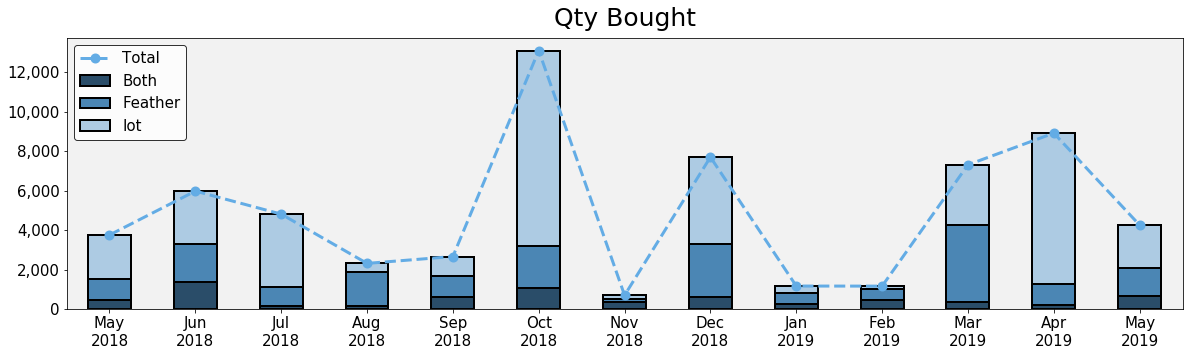

Revenue


,Both,Feather,Iot,Total
May 2018,"$6,320","$7,275","$13,493","$27,088"
May 2019,"$12,187","$14,958","$18,404","$45,548"
Yoy % Change,92.8%,105.6%,36.4%,68.1%


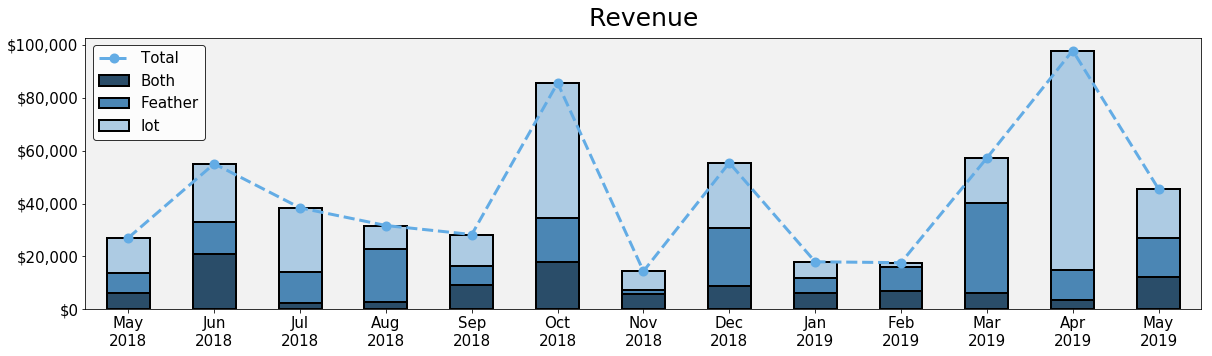

Avg Price


,Both,Feather,Iot,Overall Avg Price
May 2018,$13.62,$6.66,$6.10,$7.19
May 2019,$17.43,$10.66,$8.50,$10.67
Yoy % Change,28.0%,60.0%,39.4%,48.5%


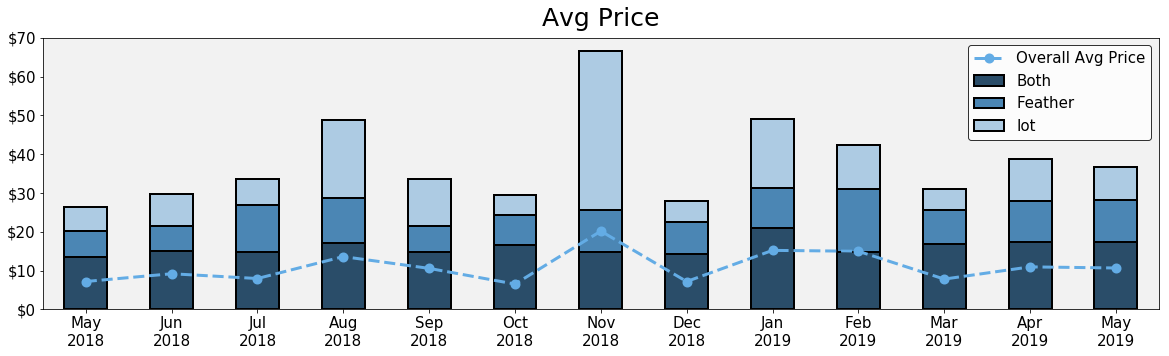

In [17]:
for k,v in dict_.items():
    
    if k == 'avg price':
        fmt = '${:,.0f}'
        fmt2 = ['m2','m2','p1']
    elif k == 'revenue':
        fmt = '${:,.0f}'
        fmt2 = ['m0','m0','p1']        
    else:
        fmt = '{:,.0f}'
        fmt2 = ['n0','n0','p1']
        
    df = dict_[k]
    df.columns = [x.title() for x in df.columns]
    
    z = df.index[-1][-3:]
    summary = df[df.index.str.contains(z)].copy()
    summary.index = [calendar.month_abbr[int(x[-2:])] + ' ' + str(x[:4]) for x in summary.index]
    summary.loc['YoY % Change'] = summary.iloc[1,:]/summary.iloc[0,:] - 1

    print(k.title())
    display(summary.T.format_(fmt2).T)    
    report_dict[k + ' table'] = summary.T.format_(fmt2).T.to_html(index = True)
    report_dict[k + ' data'] = summary
        
    fig, ax = plt.subplots(figsize = (20,5))
    
    df.iloc[:,:3].plot(kind = 'bar',
                       stacked = True,
                       color = list(colors.values())[:3],
                       edgecolor = 'black',
                       lw = 2,
                       ax = ax)
    df.iloc[:,-1].plot(lw = 3,
                       ls = '--',
                       marker = 'o',
                       mew = 4, 
                       color = list(colors.values())[4],
                       ax = ax)
    
    ax.legend(fontsize = 15, edgecolor = 'black')
    ax.set_title(k.title(), fontsize = 25, y = 1.02)
    ax.set_xticklabels(jb_dates(pd.Series(df.index), 'year and month xticks'), fontsize = 15, rotation = 0)
    ax.set_xlabel('')
    ax.set_facecolor('#f2f2f2')
    ax.set_yticklabels([fmt.format(x) for x in ax.get_yticks()], fontsize = 15)
    
    plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
    
    plt.show()    

### Report Summary

In [18]:
v1 = report_dict['qty bought data'].loc['YoY % Change','Total']
v2 = report_dict['revenue data'].loc['YoY % Change','Total']
v3 = report_dict['avg price data'].loc['YoY % Change','Overall Avg Price']

wrt = 'Year over year, the overall quantity sold {} {:,.1f}%, revenue {} {:,.1f}% and the overall avg price {} {:,.1f}%. See below for in-depth numbers and charts.'.format('decreased' if v1 < 0 else 'increased', np.abs(v1) * 100,
                                                                                                                                                                            'decreased' if v2 < 0 else 'increased', np.abs(v2) * 100,
                                                                                                                                                                            'decreased' if v3 < 0 else 'increased', np.abs(v3) * 100)

report_dict['summary'] = wrt

### HTML and PDF report

In [23]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'year_and_month':report_dict['year and month'],
                    'now':report_dict['now'],
                    'summary':report_dict['summary'],
                    'qty_bought_table':report_dict['qty bought table'],
                    'revenue_table':report_dict['revenue table'],
                    'avg_price_table':report_dict['avg price table']}

    html_out = template.render(template_vars)

    from weasyprint import HTML
    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [24]:
print('done')

done
